# Model comparison

In [103]:
import os
import sys
import pandas as pd
import re
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
plt.rcParams['font.family'] = 'serif'

# Gupta GHMI performance for comparison

Gupta and colleagues test their index on a dataset of size 679, of which 118 are healthy and 561 are unhealthy. They have 91 true positives, 27 false negatives, 167 false positives, and 394 true negatives. 

In [105]:
# load data
root = Path.cwd().parents[1]

# given values from Gupta paper
TP = 91
FN = 27
FP = 167
TN = 394

# calculating metrics for class 1
precision_1 = TP / (TP + FP)
recall_1 = TP / (TP + FN)
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
support_1 = TP + FN

# calculating metrics for class 0
precision_0 = TN / (TN + FN)
recall_0 = TN / (TN + FP)
f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
support_0 = TN + FP

# calculating overall accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# macro average of precision, recall, f1-score, and support
macro_precision = (precision_0 + precision_1) / 2
macro_recall = (recall_0 + recall_1) / 2
macro_f1_score = (f1_score_0 + f1_score_1) / 2
macro_support = (support_0 + support_1) / 2

# weighted average of precision, recall, f1-score, and support
total_support = support_0 + support_1
weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_support
weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_support
weighted_f1_score = (f1_score_0 * support_0 + f1_score_1 * support_1) / total_support
weighted_support = total_support

# specify number of decimals
ndecimals = 3

results = {
    "Overall accuracy": round(accuracy, ndecimals),
    "Class 0": {
        "Precision": round(precision_0, ndecimals),
        "Recall": round(recall_0, ndecimals),
        "F1-score": round(f1_score_0, ndecimals),
        "Support": support_0
    },
    "Class 1": {
        "Precision": round(precision_1, ndecimals),
        "Recall": round(recall_1, ndecimals),
        "F1-score": round(f1_score_1, ndecimals),
        "Support": support_1
    },
    "Macro average": {
        "Precision": round(macro_precision, ndecimals),
        "Recall": round(macro_recall, ndecimals),
        "F1-score": round(macro_f1_score, ndecimals),
        "Support": macro_support
    },
    "Weighted average": {
        "Precision": round(weighted_precision, ndecimals),
        "Recall": round(weighted_recall, ndecimals),
        "F1-score": round(weighted_f1_score, ndecimals),
        "Support": weighted_support
    }
}

import pandas as pd

# converting the results to a DataFrame for better visualisation
results_df = pd.DataFrame(results)
results_df


# preparing content for text file
text_content = f"""
GHMI - test - Accuracy: {results['Overall accuracy']}
Classification Report:
0: {{'precision': {results['Class 0']['Precision']}, 'recall': {results['Class 0']['Recall']}, 'f1-score': {results['Class 0']['F1-score']}, 'support': {results['Class 0']['Support']}}}
1: {{'precision': {results['Class 1']['Precision']}, 'recall': {results['Class 1']['Recall']}, 'f1-score': {results['Class 1']['F1-score']}, 'support': {results['Class 1']['Support']}}}
accuracy: {results['Overall accuracy']}
macro avg: {{'precision': {results['Macro average']['Precision']}, 'recall': {results['Macro average']['Recall']}, 'f1-score': {results['Macro average']['F1-score']}, 'support': {results['Macro average']['Support']}}}
weighted avg: {{'precision': {results['Weighted average']['Precision']}, 'recall': {results['Weighted average']['Recall']}, 'f1-score': {results['Weighted average']['F1-score']}, 'support': {results['Weighted average']['Support']}}}
"""


file_path = root / 'results/model_reports/GMHI/GMHI_results.txt'
file_path.parent.mkdir(parents=True, exist_ok=True)
file_path.write_text(text_content)

395

## 0. Read in model reports & ROC AUC data from test splits

In [106]:
# define root dir
root = Path.cwd().parents[1]
results_root = root / "results/model_reports/"

# list all subdirectories in the results directory
subdirs = [x for x in results_root.iterdir() if x.is_dir()]
subdirs 

[PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_undersampled'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/CLR_PCA_LowAbFilt_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/50SPC_CLR_smote'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/r

In [107]:
# initialise an empty list to store DataFrames
dfs = []

# loop through each subdirectory and read the roc_auc_scores.txt file
for subdir in subdirs:
    file_path = subdir / 'roc_auc_scores.txt'
    if file_path.exists():
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # initialise lists to store the data
        models = []
        rocaucs = []
        subdir_names = []
        
        # parse each line
        for line in lines:
            model, rocauc = line.split(': ROC AUC = ')
            models.append(model.strip())
            rocaucs.append(float(rocauc.strip()))
            subdir_names.append(subdir.name) 
        
        # create a DataFrame for the current file
        data = {'Model': models, 'ROCAUC': rocaucs, 'Directory': subdir_names}
        df = pd.DataFrame(data)
        
        # add the DataFrame to the list
        dfs.append(df)
        
# concatenate all DataFrames
rocauc_df = pd.concat(dfs, ignore_index=True)

# sort the ROCAUC from high to low
rocauc_df = rocauc_df.sort_values(by='ROCAUC', ascending=False)
rocauc_df


,Model,ROCAUC,Directory
117,KNN_Optimized,0.88,CLR_PCA_LowAbFilt
114,XGBoost_Optimized,0.86,CLR_PCA_LowAbFilt
113,XGBoost_Basic,0.86,CLR_PCA_LowAbFilt
111,Random_Forest_Basic,0.85,CLR_PCA_LowAbFilt
112,Random_Forest_Optimized,0.85,CLR_PCA_LowAbFilt
...,...,...,...
108,Chance_Class_Classifier,0.50,50SPC_smote
107,Majority_Class_Classifier,0.50,50SPC_smote
75,Chance_Class_Classifier,0.50,50SPC
97,Chance_Class_Classifier,0.50,50SPC_CLR_smote


In [108]:
# define the root directory
root = Path.cwd().parents[1]
results_root = root / "results/model_reports/"

# function to extract data
def extract_metrics(section):
    metrics = {}
    accuracy = section[1]
    report = section[2]

    # extract accuracy
    metrics['Accuracy'] = float(accuracy)
    
    # extract individual class metrics
    class_metrics = re.findall(r'(\d.\d): \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    for metric in class_metrics:
        class_id = metric[0]
        metrics[f'Class_{class_id}_precision'] = float(metric[1])
        metrics[f'Class_{class_id}_recall'] = float(metric[2])
        metrics[f'Class_{class_id}_f1-score'] = float(metric[3])
        metrics[f'Class_{class_id}_support'] = float(metric[4])
    
    # extract macro avg metrics
    macro_avg = re.search(r'macro avg: \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    metrics['macro_avg_precision'] = float(macro_avg.group(1))
    metrics['macro_avg_recall'] = float(macro_avg.group(2))
    metrics['macro_avg_f1-score'] = float(macro_avg.group(3))
    metrics['macro_avg_support'] = float(macro_avg.group(4))
    
    # extract weighted avg metrics
    weighted_avg = re.search(r'weighted avg: \{\'precision\': ([\d.]+), \'recall\': ([\d.]+), \'f1-score\': ([\d.]+), \'support\': ([\d.]+)\}', report)
    metrics['weighted_avg_precision'] = float(weighted_avg.group(1))
    metrics['weighted_avg_recall'] = float(weighted_avg.group(2))
    metrics['weighted_avg_f1-score'] = float(weighted_avg.group(3))
    metrics['weighted_avg_support'] = float(weighted_avg.group(4))
    
    return metrics

# list to store all data
all_data = []

In [109]:
# list all files in results_root
files = list(results_root.glob('**/*.txt'))
files

[PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Random_Forest_Basic_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Elastic_Net_Logistic_Regression_Best_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/Random_Forest_Optimized_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/XGBoost_Basic_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/best_params.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/XGBoost_Optimized_results.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/model_reports/baseline_smote/roc_auc_scores.txt'),
 PosixPath('/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/results/

In [110]:
# iterate over all directories in the results/model_reports directory

# iterate over all subdirs in the results_root regardless of pattern in the name
for results in results_root.glob("*/"):
    # extract the directory name
    directory_name = results.name
    
    # iterate over all txt files in the directory
    for txt_file in results.glob("*.txt"):
        # read the text file
        with open(txt_file, 'r') as file:
            data = file.read()
        
        # extract the model name from the file path
        model_name = txt_file.stem.replace('_results', '')

        # generalize the regular expression to split the data into sections
        sections = re.split(r'(\w+) - (\w+) - Accuracy: ([\d.]+)', data)[1:]

        # process each section and store the results in a list
        for i in range(0, len(sections), 4):
            classifier_name = sections[i]
            split_type = sections[i+1]
            accuracy = sections[i+2]
            section_data = sections[i+3]
            section_metrics = extract_metrics([split_type, accuracy, section_data])
            section_metrics['Split'] = split_type
            section_metrics['Model'] = model_name
            section_metrics['Directory'] = directory_name
            all_data.append(section_metrics)

# create DataFrame
combined_df = pd.DataFrame(all_data)

# ensure 'Directory' is the first column, 'Model' is the second column, and 'Split' is the third column
columns = ['Directory', 'Model', 'Split'] + [col for col in combined_df.columns if col not in ['Directory', 'Model', 'Split']]
combined_df = combined_df[columns]

for directory in combined_df['Directory'].unique():
    print(f"Directory: {directory}")

combined_df

Directory: baseline_smote
Directory: 50SPC_undersampled
Directory: 50SPC_CLR
Directory: 50SPC_CLR_undersampled
Directory: baseline_undersampled
Directory: CLR_PCA_LowAbFilt_smote
Directory: 50SPC
Directory: baseline
Directory: 50SPC_CLR_smote
Directory: 50SPC_smote
Directory: CLR_PCA_LowAbFilt
Directory: CLR_PCA_LowAbFilt_undersampled
Directory: GMHI


,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support
0,baseline_smote,Random_Forest_Basic,train,0.844093,0.844779,0.844093,0.844015,8024.0,0.844779,0.844093,0.844015,8024.0
1,baseline_smote,Random_Forest_Basic,val,0.682334,0.636295,0.647435,0.639810,1234.0,0.698104,0.682334,0.688552,1234.0
2,baseline_smote,Random_Forest_Basic,test,0.719611,0.679459,0.696844,0.684817,1234.0,0.737884,0.719611,0.726061,1234.0
3,baseline_smote,Elastic_Net_Logistic_Regression_Best,train,0.666750,0.667650,0.666750,0.666302,8024.0,0.667650,0.666750,0.666302,8024.0
4,baseline_smote,Elastic_Net_Logistic_Regression_Best,val,0.653160,0.640117,0.665035,0.633472,1234.0,0.713827,0.653160,0.666929,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...
368,CLR_PCA_LowAbFilt_undersampled,Neural_Network,test,0.627419,0.599631,0.615529,0.597131,1240.0,0.672353,0.627419,0.640960,1240.0
369,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,train,1.000000,1.000000,1.000000,1.000000,3482.0,1.000000,1.000000,1.000000,3482.0
370,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,val,0.634677,0.622092,0.644271,0.613999,1240.0,0.697604,0.634677,0.649447,1240.0
371,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,test,0.637097,0.620158,0.641446,0.614214,1240.0,0.694567,0.637097,0.651494,1240.0


In [111]:
# Ensure 'Model' is 'Random_Forest_Optimized' where 'Directory' is 'GMHI'
combined_df.loc[combined_df['Directory'] == 'GMHI', 'Model'] = 'Random_Forest_Optimized'

# Verify the changes
combined_df

,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support
0,baseline_smote,Random_Forest_Basic,train,0.844093,0.844779,0.844093,0.844015,8024.0,0.844779,0.844093,0.844015,8024.0
1,baseline_smote,Random_Forest_Basic,val,0.682334,0.636295,0.647435,0.639810,1234.0,0.698104,0.682334,0.688552,1234.0
2,baseline_smote,Random_Forest_Basic,test,0.719611,0.679459,0.696844,0.684817,1234.0,0.737884,0.719611,0.726061,1234.0
3,baseline_smote,Elastic_Net_Logistic_Regression_Best,train,0.666750,0.667650,0.666750,0.666302,8024.0,0.667650,0.666750,0.666302,8024.0
4,baseline_smote,Elastic_Net_Logistic_Regression_Best,val,0.653160,0.640117,0.665035,0.633472,1234.0,0.713827,0.653160,0.666929,1234.0
...,...,...,...,...,...,...,...,...,...,...,...,...
368,CLR_PCA_LowAbFilt_undersampled,Neural_Network,test,0.627419,0.599631,0.615529,0.597131,1240.0,0.672353,0.627419,0.640960,1240.0
369,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,train,1.000000,1.000000,1.000000,1.000000,3482.0,1.000000,1.000000,1.000000,3482.0
370,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,val,0.634677,0.622092,0.644271,0.613999,1240.0,0.697604,0.634677,0.649447,1240.0
371,CLR_PCA_LowAbFilt_undersampled,KNN_Optimized,test,0.637097,0.620158,0.641446,0.614214,1240.0,0.694567,0.637097,0.651494,1240.0


In [112]:
# Create subset with all test splits
test_splits = combined_df[combined_df['Split'].str.contains('test')]

# Combine test_splits with rocauc_df based on match in Directory and Model
test_eval = pd.merge(test_splits, rocauc_df, on=['Directory', 'Model'], how='left')

# Assign NaN to rows with no ROCAUC value
test_eval['ROCAUC'] = test_eval['ROCAUC'].where(test_eval['ROCAUC'].notna(), np.nan)

# Clean data a bit
filter_out = ['Basic', 'Deterministic', 'Chance_Class_Classifier', 'Majority_Class_Classifier']

# Filter out the rows in which value in 'Model' is exactly 'Logistic_Regression_Best' but doesn't contain the string 'Elastic_net'
test_eval = test_eval[~((test_eval['Model'] == 'Logistic_Regression_Best') & (~test_eval['Model'].str.contains('Elastic_net')))]

pattern = '|'.join(filter_out)
test_eval = test_eval[~test_eval['Model'].str.contains(pattern)]

# Sort the data based on 'macro_avg_recall'
test_eval = test_eval.sort_values(by='macro_avg_recall', ascending=False)

# Round all the numeric columns to 3 decimals
test_eval = test_eval.round(3)

test_eval


,Directory,Model,Split,Accuracy,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,weighted_avg_support,ROCAUC
120,CLR_PCA_LowAbFilt,KNN_Optimized,test,0.828,0.810,0.781,0.792,1234.0,0.824,0.828,0.824,1234.0,0.88
114,CLR_PCA_LowAbFilt,XGBoost_Optimized,test,0.815,0.799,0.757,0.771,1234.0,0.811,0.815,0.808,1234.0,0.86
119,CLR_PCA_LowAbFilt,Neural_Network,test,0.801,0.773,0.756,0.763,1234.0,0.797,0.801,0.798,1234.0,0.84
112,CLR_PCA_LowAbFilt,Random_Forest_Optimized,test,0.815,0.801,0.754,0.770,1234.0,0.811,0.815,0.807,1234.0,0.85
132,GMHI,Random_Forest_Optimized,test,0.714,0.644,0.737,0.643,339.5,0.835,0.714,0.747,679.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,50SPC_CLR,Elastic_Net_Logistic_Regression_Best,test,0.701,0.629,0.523,0.474,1234.0,0.660,0.701,0.610,1234.0,0.67
27,50SPC_CLR,Linear_SVC_Optimized,test,0.700,0.630,0.517,0.459,1234.0,0.659,0.700,0.601,1234.0,0.65
67,50SPC,Elastic_Net_Logistic_Regression_Best,test,0.699,0.749,0.505,0.422,1234.0,0.730,0.699,0.580,1234.0,0.64
75,50SPC,Neural_Network,test,0.697,0.599,0.502,0.416,1234.0,0.638,0.697,0.575,1234.0,0.61


## 1. Save macro_avg_recall result tables

In [113]:
# First I prepare a folder in which I can save the result figs
figs_root = root / "figs/"
figs_root.mkdir(exist_ok=True)

In [114]:
# ---- MAKE THE OVERALL RESULTS DF ---- # 
test_eval_macro_avg_recall = test_eval[['Directory', 'Model', 'macro_avg_recall']]
# restructure the dataframe
test_eval_macro_avg_recall = test_eval_macro_avg_recall.pivot(index='Directory', columns='Model', values='macro_avg_recall').reset_index()
# display the final dataframe
test_eval_macro_avg_recall

macro_avg_recall_df = test_eval_macro_avg_recall.rename(columns={
    'Elastic_Net_Logistic_Regression_Best': 'LogReg',
    'KNN_Optimized': 'KNN',
    'Neural_Network': 'NN',
    'Random_Forest_Optimized': 'RF',
    'XGBoost_Optimized': 'XGB',
    'Linear_SVC_Optimized': 'SVC'
})

macro_avg_recall_df = macro_avg_recall_df[['Directory', 'RF', 'XGB','SVC','LogReg','KNN','NN']]
# make df a pandas dataframe
macro_avg_recall_df = pd.DataFrame(macro_avg_recall_df)
macro_avg_recall_df

Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
0,50SPC,0.579,0.553,0.501,0.505,0.551,0.502
1,50SPC_CLR,0.560,0.573,0.517,0.523,0.557,0.533
2,50SPC_CLR_smote,0.592,0.612,0.617,0.620,0.559,0.600
3,50SPC_CLR_undersampled,0.629,0.637,0.622,0.618,0.566,0.605
4,50SPC_smote,0.605,0.588,0.592,0.596,0.566,0.594
5,50SPC_undersampled,0.622,0.625,0.599,0.599,0.580,0.589
6,CLR_PCA_LowAbFilt,0.754,0.757,0.692,0.701,0.781,0.756
7,CLR_PCA_LowAbFilt_smote,0.600,0.613,0.572,0.579,0.645,0.610
8,CLR_PCA_LowAbFilt_undersampled,0.654,0.654,0.617,0.618,0.641,0.616
9,GMHI,0.737,NaN,NaN,NaN,NaN,NaN


### 1.1 Create result table for data w/o balancing

In [122]:
# subset test_eval where Directory doesn't coontain 'undersampled' or 'smote'
imbal_macro_avg_recall = macro_avg_recall_df[~macro_avg_recall_df['Directory'].str.contains('undersampled', case=False)]
# 
# Remove rows where 'Directory'=='50SPC'
imbal_macro_avg_recall = imbal_macro_avg_recall[imbal_macro_avg_recall['Directory'] != '50SPC']

# Remove columns containing the string 'smote'
imbal_macro_avg_recall = imbal_macro_avg_recall.loc[:, ~imbal_macro_avg_recall.columns.str.contains('smote|GMHI', case=False)]

# Remove rows where any column contains the string 'smote'
imbal_macro_avg_recall = imbal_macro_avg_recall[~imbal_macro_avg_recall.apply(lambda row: row.astype(str).str.contains('smote|undersampled', case=False).any(), axis=1)]

imbal_macro_avg_recall

# replace value '50SPC_CLR' with '50SPC'
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('50SPC_CLR', '50SPC')
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
imbal_macro_avg_recall['Directory'] = imbal_macro_avg_recall['Directory'].replace('baseline', 'Baseline')
imbal_macro_avg_recall

# multiply all numeric values by 100
imbal_macro_avg_recall.iloc[:,1:] = imbal_macro_avg_recall.iloc[:,1:] * 100

# print the column names in imbalanced
for col in imbal_macro_avg_recall.columns:
    print(col)

imbal_macro_avg_recall.to_csv(figs_root / 'imbalanced_macroavg_recall.csv', index=False)

imbal_macro_avg_recall

Directory
RF
XGB
SVC
LogReg
KNN
NN


Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
1,50SPC,56.0,57.3,51.7,52.3,55.7,53.3
6,PCA_LAF,75.4,75.7,69.2,70.1,78.1,75.6
9,GMHI,73.7,NaN,NaN,NaN,NaN,NaN
10,Baseline,64.9,64.5,61.4,61.0,65.5,59.0


### 1.2 Create result table for data w undersampling

In [116]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_macro_avg_recall_df = macro_avg_recall_df[macro_avg_recall_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_macro_avg_recall_df = undersampled_macro_avg_recall_df[undersampled_macro_avg_recall_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_macro_avg_recall_df['Directory'] = undersampled_macro_avg_recall_df['Directory'].replace('baseline_undersampled', 'Baseline')

# save undersampled as a csv file
undersampled_macro_avg_recall_df.to_csv(figs_root / 'undersampled_macroavg_recall.csv', index=False)
undersampled_macro_avg_recall_df


Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
3,50SPC,0.629,0.637,0.622,0.618,0.566,0.605
8,PCA_LAF,0.654,0.654,0.617,0.618,0.641,0.616
9,GMHI,0.737,NaN,NaN,NaN,NaN,NaN
12,Baseline,0.712,0.713,0.690,0.689,0.697,0.710


### 1.3 Create result table for data w SMOTE

In [ ]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_macro_avg_recall_df = macro_avg_recall_df[macro_avg_recall_df['Directory'].str.contains('smote', na=False)]
smote_macro_avg_recall_df = smote_macro_avg_recall_df[smote_macro_avg_recall_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_macro_avg_recall_df['Directory'] = smote_macro_avg_recall_df['Directory'].replace('baseline_smote', 'Baseline')

smote_macro_avg_recall_df.to_csv(figs_root / 'smote_macroavg_recall.csv', index=False)

smote_macro_avg_recall_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.592,0.612,0.62,0.559,0.590
7,PCA_LAF,0.601,0.629,0.58,0.666,0.600
11,Baseline,0.697,0.704,0.68,0.672,0.687


## 2. Save macro_avg_f1-score result tables

In [128]:
test_eval_macro_avg_f1 = test_eval[['Directory', 'Model', 'macro_avg_f1-score']]
test_eval_macro_avg_f1

# ---- MAKE THE OVERALL RESULTS DF ---- # 
test_eval_macro_avg_f1 = test_eval[['Directory', 'Model', 'macro_avg_f1-score']]
# restructure the dataframe
test_eval_macro_avg_f1 = test_eval_macro_avg_f1.pivot(index='Directory', columns='Model', values='macro_avg_f1-score').reset_index()
# display the final dataframe
test_eval_macro_avg_f1

macro_avg_f1_df = test_eval_macro_avg_f1.rename(columns={
    'Elastic_Net_Logistic_Regression_Best': 'LogReg',
    'KNN_Optimized': 'KNN',
    'Neural_Network': 'NN',
    'Random_Forest_Optimized': 'RF',
    'Linear_SVC_Optimized': 'SVC',
    'XGBoost_Optimized': 'XGB'
})

macro_avg_f1_df = macro_avg_f1_df[['Directory', 'RF', 'XGB', 'SVC', 'LogReg','KNN','NN']]
# make df a pandas dataframe
macro_avg_f1_df = pd.DataFrame(macro_avg_f1_df)
macro_avg_f1_df

Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
0,50SPC,0.578,0.542,0.413,0.422,0.552,0.416
1,50SPC_CLR,0.554,0.572,0.459,0.474,0.558,0.512
2,50SPC_CLR_smote,0.592,0.609,0.582,0.583,0.550,0.578
3,50SPC_CLR_undersampled,0.573,0.587,0.581,0.577,0.525,0.584
4,50SPC_smote,0.605,0.588,0.506,0.505,0.557,0.531
5,50SPC_undersampled,0.568,0.592,0.511,0.510,0.533,0.513
6,CLR_PCA_LowAbFilt,0.770,0.771,0.705,0.713,0.792,0.763
7,CLR_PCA_LowAbFilt_smote,0.605,0.617,0.572,0.576,0.623,0.603
8,CLR_PCA_LowAbFilt_undersampled,0.612,0.624,0.590,0.592,0.614,0.597
9,GMHI,0.643,NaN,NaN,NaN,NaN,NaN


### 2.1 Create result table for data w/o balancing

In [133]:
# remove rows from the DataFrame where the 'Directory' column contains the strings 'undersampled' or 'smote' 
imbal_macro_avg_f1 = macro_avg_f1_df[~macro_avg_f1_df['Directory'].str.contains('undersampled|smote', case=False)]
# remove row where 'Directory'=='50SPC'
imbal_macro_avg_f1 = imbal_macro_avg_f1[imbal_macro_avg_f1['Directory'] != '50SPC']
imbal_macro_avg_f1

# replace value '50SPC_CLR' with '50SPC'
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('50SPC_CLR', '50SPC')
# replace value 'CLR_PCA_LowAbFilt' with 'PCA_LAF'
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
# replace value 'baseline' with 'Baseline'
imbal_macro_avg_f1['Directory'] = imbal_macro_avg_f1['Directory'].replace('baseline', 'Baseline')
imbal_macro_avg_f1

# multiply each numeric value by 100
imbal_macro_avg_f1.iloc[:,1:] = imbal_macro_avg_f1.iloc[:,1:] * 100
imbal_macro_avg_f1

Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
1,50SPC,55.4,57.2,45.9,47.4,55.8,51.2
6,PCA_LAF,77.0,77.1,70.5,71.3,79.2,76.3
9,GMHI,64.3,NaN,NaN,NaN,NaN,NaN
10,Baseline,65.5,65.4,62.1,61.6,66.3,58.8


In [134]:
imbal_macro_avg_f1.to_csv(figs_root / 'imbalanced_macroavg_f1.csv', index=False)
imbal_macro_avg_f1

Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
1,50SPC,55.4,57.2,45.9,47.4,55.8,51.2
6,PCA_LAF,77.0,77.1,70.5,71.3,79.2,76.3
9,GMHI,64.3,NaN,NaN,NaN,NaN,NaN
10,Baseline,65.5,65.4,62.1,61.6,66.3,58.8


### 2.2 Create result table for data w undersampling

In [ ]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_macro_avg_f1_df = macro_avg_f1_df[macro_avg_f1_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_macro_avg_f1_df = undersampled_macro_avg_f1_df[undersampled_macro_avg_f1_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_macro_avg_f1_df['Directory'] = undersampled_macro_avg_f1_df['Directory'].replace('baseline_undersampled', 'Baseline')

undersampled_macro_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
3,50SPC,0.573,0.587,0.577,0.525,0.570
8,GMHI,0.643,NaN,NaN,NaN,NaN
11,Baseline,0.678,0.679,0.659,0.628,0.632


In [ ]:
# save undersampled as a csv file
undersampled_macro_avg_f1_df.to_csv(figs_root / 'undersampled_macroavg_f1.csv', index=False)


### 2.3 Create result table for data w SMOTE

In [ ]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_macro_avg_f1_df = macro_avg_f1_df[macro_avg_f1_df['Directory'].str.contains('smote|GMHI', na=False)]
smote_macro_avg_f1_df = smote_macro_avg_f1_df[smote_macro_avg_f1_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_macro_avg_f1_df['Directory'] = smote_macro_avg_f1_df['Directory'].replace('baseline_smote', 'Baseline')

smote_macro_avg_f1_df.to_csv(figs_root / 'smote_macroavg_f1.csv', index=False)

smote_macro_avg_f1_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.592,0.609,0.583,0.550,0.583
7,PCA_LAF,0.606,0.634,0.579,0.643,0.625
8,GMHI,0.643,NaN,NaN,NaN,NaN
10,Baseline,0.677,0.682,0.656,0.651,0.682


## 3. Create weighted_avg_f1-score result tables

In [136]:
# ---- MAKE THE OVERALL RESULTS DF ---- # 
test_eval_weighted_avg_f1 = test_eval[['Directory', 'Model', 'weighted_avg_f1-score']]
# restructure the dataframe
test_eval_weighted_avg_f1 = test_eval_weighted_avg_f1.pivot(index='Directory', columns='Model', values='weighted_avg_f1-score').reset_index()
# display the final dataframe
test_eval_weighted_avg_f1

weighted_avg_f1_df = test_eval_weighted_avg_f1.rename(columns={
    'Elastic_Net_Logistic_Regression_Best': 'LogReg',
    'KNN_Optimized': 'KNN',
    'Neural_Network': 'NN',
    'Random_Forest_Optimized': 'RF',
    'Linear_SVC_Optimized': 'SVC',
    'XGBoost_Optimized': 'XGB'
})

weighted_avg_f1_df = weighted_avg_f1_df[['Directory', 'RF', 'XGB','SVC', 'LogReg','KNN','NN']]
# make df a pandas dataframe
weighted_avg_f1_df = pd.DataFrame(weighted_avg_f1_df)
weighted_avg_f1_df

Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
0,50SPC,0.670,0.646,0.574,0.580,0.635,0.575
1,50SPC_CLR,0.652,0.664,0.601,0.610,0.636,0.627
2,50SPC_CLR_smote,0.656,0.666,0.614,0.613,0.605,0.618
3,50SPC_CLR_undersampled,0.594,0.611,0.610,0.605,0.552,0.626
4,50SPC_smote,0.667,0.652,0.508,0.505,0.610,0.546
5,50SPC_undersampled,0.590,0.625,0.514,0.511,0.557,0.521
6,CLR_PCA_LowAbFilt,0.807,0.808,0.755,0.759,0.824,0.798
7,CLR_PCA_LowAbFilt_smote,0.682,0.685,0.639,0.637,0.663,0.656
8,CLR_PCA_LowAbFilt_undersampled,0.642,0.659,0.628,0.630,0.651,0.641
9,GMHI,0.747,NaN,NaN,NaN,NaN,NaN


### 3.1. Create result table for data w/o balancing

In [138]:
imbal_weighted_avg_f1 = weighted_avg_f1_df

# Remove rows where 'Directory'=='50SPC'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1[imbal_weighted_avg_f1['Directory'] != '50SPC']

# Remove columns containing the string 'smote'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1.loc[:, ~imbal_weighted_avg_f1.columns.str.contains('smote', case=False)]

# Remove rows where any column contains the string 'smote'
imbal_weighted_avg_f1 = imbal_weighted_avg_f1[~imbal_weighted_avg_f1.apply(lambda row: row.astype(str).str.contains('smote|undersampled', case=False).any(), axis=1)]

imbal_weighted_avg_f1

# replace value '50SPC_CLR' with '50SPC'
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('50SPC_CLR', '50SPC')
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA_LAF')
imbal_weighted_avg_f1['Directory'] = imbal_weighted_avg_f1['Directory'].replace('baseline', 'Baseline')
imbal_weighted_avg_f1

# multiply all values by 100
imbal_weighted_avg_f1.iloc[:,1:] = imbal_weighted_avg_f1.iloc[:,1:] * 100

imbal_weighted_avg_f1.to_csv(figs_root / 'imbalanced_weightedavg_f1.csv', index=False)
imbal_weighted_avg_f1


Model,Directory,RF,XGB,SVC,LogReg,KNN,NN
1,50SPC,65.2,66.4,60.1,61.0,63.6,62.7
6,PCA_LAF,80.7,80.8,75.5,75.9,82.4,79.8
9,GMHI,74.7,NaN,NaN,NaN,NaN,NaN
10,Baseline,71.5,71.9,70.1,69.8,72.3,68.3


### 3.2 Create result table for data w undersampling

In [ ]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
undersampled_weighted_avg_f1_df = weighted_avg_f1_df[weighted_avg_f1_df['Directory'].str.contains('undersampled|GMHI', na=False)]
undersampled_weighted_avg_f1_df = undersampled_weighted_avg_f1_df[undersampled_weighted_avg_f1_df['Directory'] != '50SPC_undersampled'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 
# replace value '50SPC_CLR' with '50SPC'
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('50SPC_CLR_undersampled', '50SPC')
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_undersampled', 'PCA_LAF')
undersampled_weighted_avg_f1_df['Directory'] = undersampled_weighted_avg_f1_df['Directory'].replace('baseline_undersampled', 'Baseline')

undersampled_weighted_avg_f1_df

Model,Directory,RF,XGB,LogReg,KNN,NN
3,50SPC,0.594,0.611,0.605,0.552,0.613
8,GMHI,0.747,NaN,NaN,NaN,NaN
11,Baseline,0.709,0.710,0.692,0.661,0.704


In [ ]:
# save undersampled as a csv file
undersampled_weighted_avg_f1_df.to_csv(figs_root / 'undersampled_weightedavg_f1.csv', index=False)

### 3.3 Create result table for data w SMOTE

In [ ]:
# remove rows from where 'Directory' does not contain the string 'undersampled'
smote_weighted_avg_f1_df = weighted_avg_f1_df[weighted_avg_f1_df['Directory'].str.contains('smote|GMHI', na=False)]
smote_weighted_avg_f1_df = smote_weighted_avg_f1_df[smote_weighted_avg_f1_df['Directory'] != '50SPC_smote'] # remove the 50SPC_undersampled row because I use use 50SPC_CLR_undersampled as we always want to CLRtransform (better performance). 

# replace value '50SPC_CLR' with '50SPC'
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('50SPC_CLR_smote', '50SPC')
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('CLR_PCA_LowAbFilt_smote', 'PCA_LAF')
smote_weighted_avg_f1_df['Directory'] = smote_weighted_avg_f1_df['Directory'].replace('baseline_smote', 'Baseline')

smote_weighted_avg_f1_df.to_csv(figs_root / 'smote_weightedavg_f1.csv', index=False)

smote_weighted_avg_f1_df


Model,Directory,RF,XGB,LogReg,KNN,NN
2,50SPC,0.656,0.666,0.613,0.605,0.626
7,PCA_LAF,0.679,0.695,0.639,0.679,0.682
8,GMHI,0.747,NaN,NaN,NaN,NaN
10,Baseline,0.714,0.718,0.692,0.689,0.722


## 4. Visualisation of Model Performances

In [53]:
# subset combined_df where directory is '50SPC_CLR', 'baseline', 'CLR_PRC_LowAbFilt', or 'GMHI'

dirs_to_plot = ['50SPC_CLR', 'baseline', 'CLR_PCA_LowAbFilt']
models_to_plot = ['Random_Forest_Optimized', 'XGBoost_Optimized', 'Elastic_Net_Logistic_Regression_Best', 'KNN_Optimized', 'Neural_Network', 'Linear_SVC_Optimized', 'Majority_Class_Classifier']


# Filter the DataFrame for specific directories and models within those directories
metrics_to_plot_df = combined_df[combined_df['Directory'].isin(dirs_to_plot) & combined_df['Model'].isin(models_to_plot)]
metrics_to_plot_df

# rename Elastic_Net_Logistic_Regression_Best to LogReg
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Elastic_Net_Logistic_Regression_Best', 'LogReg')
# rename Random_Forest_Optimized to RF
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Random_Forest_Optimized', 'RF')
# rename XGBoost_Optimized to XGB
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('XGBoost_Optimized', 'XGB')
# rename KNN_Optimized to KNN
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('KNN_Optimized', 'KNN')
# rename Neural_Network to NN
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Neural_Network', 'NN')
# rename Linear_SVC_Optimized to SVC
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Linear_SVC_Optimized', 'SVC')
# rename Majority_Class_Classifier to Majority
metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Majority_Class_Classifier', 'Dummy')

# change 50SPC_CLR to 50SPC
metrics_to_plot_df['Directory'] = metrics_to_plot_df['Directory'].replace('50SPC_CLR', '50SPC')
# change CLR_PCA_LowAbFilt to PCA
metrics_to_plot_df['Directory'] = metrics_to_plot_df['Directory'].replace('CLR_PCA_LowAbFilt', 'PCA')
# chance baseline to Demographic
metrics_to_plot_df['Directory'] = metrics_to_plot_df['Directory'].replace('baseline', 'Demographic')


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_7134/1012724350.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Elastic_Net_Logistic_Regression_Best', 'LogReg')
/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_7134/1012724350.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_to_plot_df['Model'] = metrics_to_plot_df['Model'].replace('Random_Forest_Optimized', 'RF')
/var/folders/98/18p7fygn5473lcp5yfrz9s340

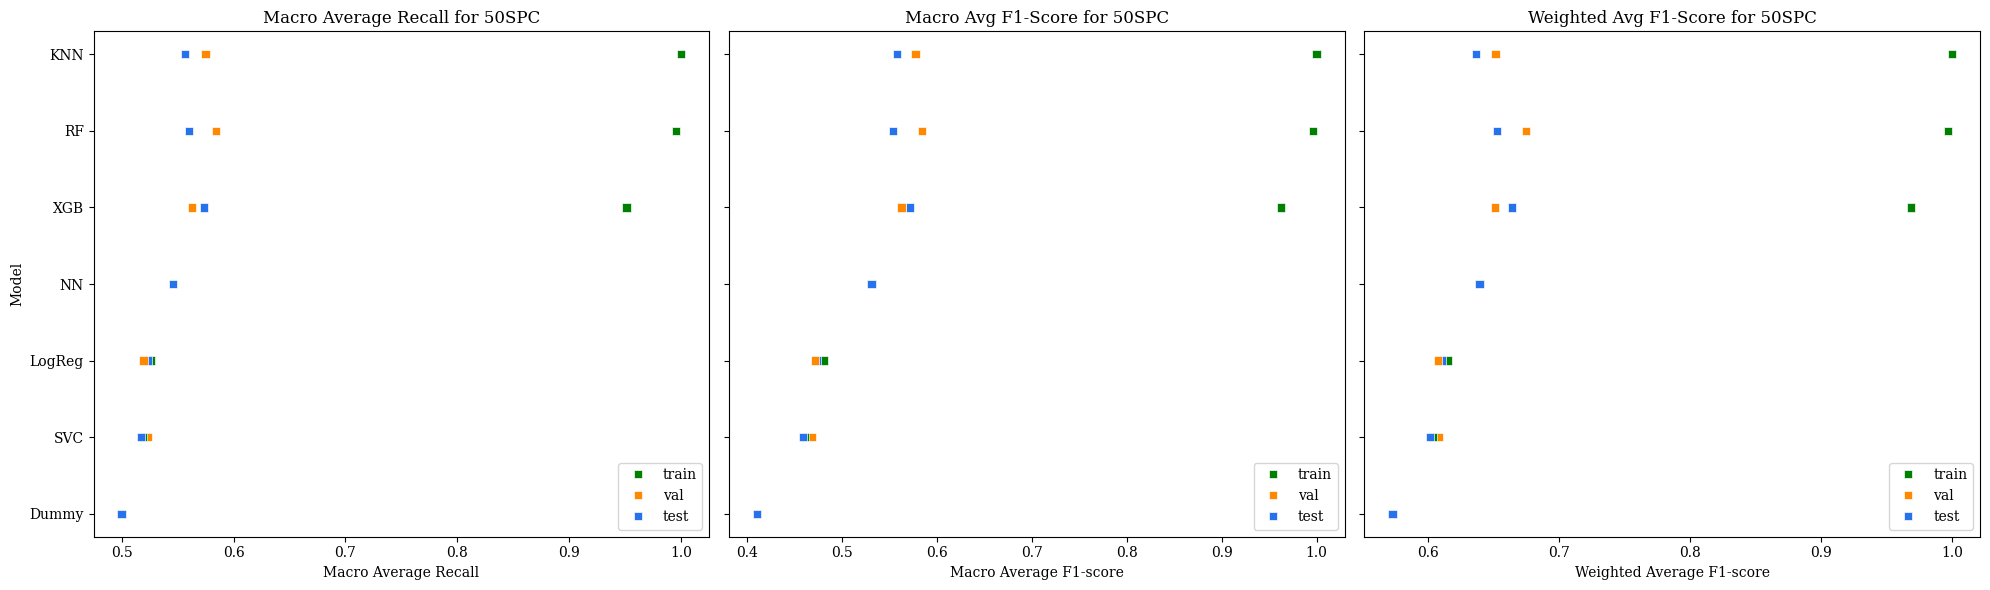

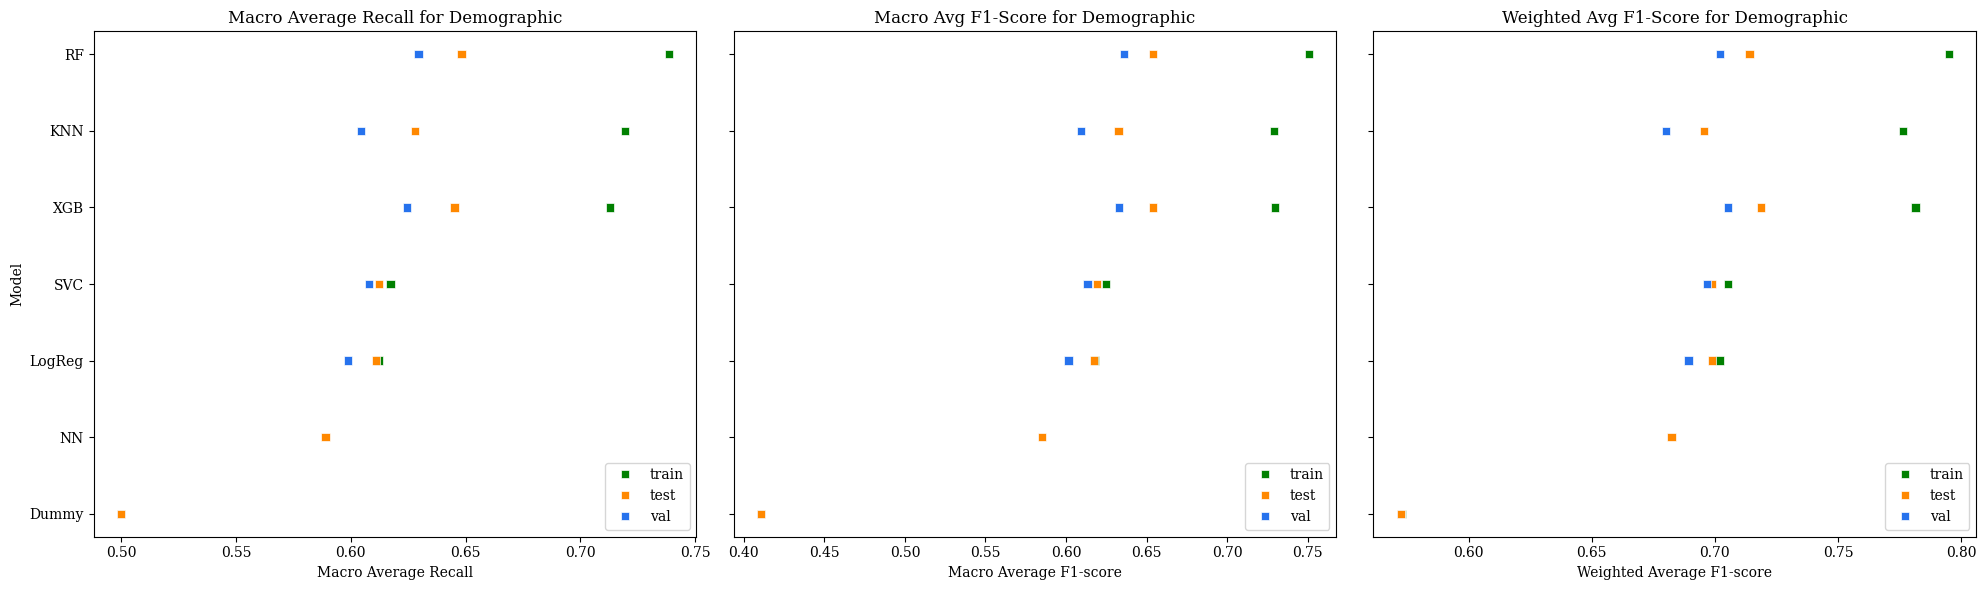

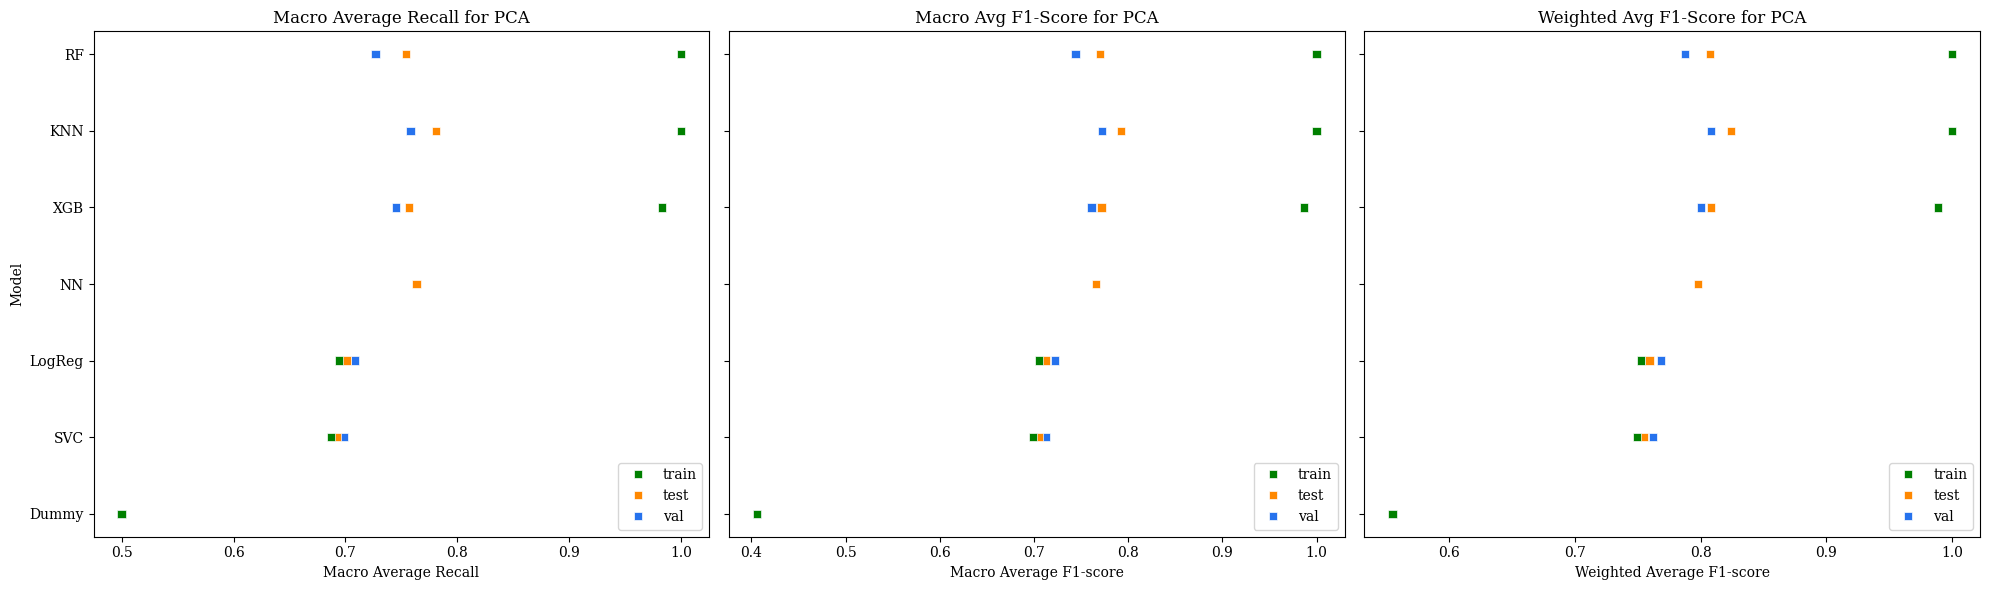

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for directory in metrics_to_plot_df['Directory'].unique():
    # Filter the DataFrame for the current directory
    subset_df = metrics_to_plot_df[metrics_to_plot_df['Directory'] == directory]
    
    # Sort the DataFrame by 'macro_avg_recall' for the first plot
    sorted_df_mar = subset_df.sort_values(by='macro_avg_recall', ascending=False)
    # Sort dataframe by 'macro_avg_f1-score' for the second plot
    sorted_df_maf1 = subset_df.sort_values(by='macro_avg_f1-score', ascending=False)
    # Sort the DataFrame by 'weighted_avg_f1-score' for the third plot
    sorted_df_waf1 = subset_df.sort_values(by='weighted_avg_f1-score', ascending=False)
    
    # Create subplots with 3 columns, sharing the y-axis
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
    # Create the scatter plot for macro_avg_recall
    mar_plot = sns.scatterplot(ax=axes[0], data=sorted_df_mar, 
                               y='Model', 
                               x='macro_avg_recall', 
                               marker='s', 
                               hue='Split', palette=['green', '#ff8800', '#2672ed']) # val, test, train
    # Set plot title for macro_avg_recall
    axes[0].set_title(f'Macro Average Recall for {directory}')
    # Set custom x-axis label
    axes[0].set_xlabel("Macro Average Recall")
    # Position the legend in the lower right corner
    mar_plot.legend(loc='lower right')

    # Create the scatter plot for macro_avg_f1-score
    maf1_plot = sns.scatterplot(ax=axes[1], data=sorted_df_maf1, 
                                y='Model', 
                                x='macro_avg_f1-score', 
                                marker='s', 
                                hue='Split', palette=['green', '#ff8800', '#2672ed'])
    # Set plot title for macro_avg_f1-score
    axes[1].set_title(f'Macro Avg F1-Score for {directory}')
    # Set custom x-axis label
    axes[1].set_xlabel("Macro Average F1-score")
    # Position the legend in the lower right corner
    maf1_plot.legend(loc='lower right')

    # Create the scatter plot for weighted_avg_f1-score
    waf1_plot = sns.scatterplot(ax=axes[2], data=sorted_df_waf1, 
                                y='Model', 
                                x='weighted_avg_f1-score', 
                                marker='s', 
                                hue='Split', palette=['green', '#ff8800', '#2672ed'])
    # Set plot title for weighted_avg_f1-score
    axes[2].set_title(f'Weighted Avg F1-Score for {directory}')
    # Set custom x-axis label
    axes[2].set_xlabel("Weighted Average F1-score")
    # Position the legend in the lower right corner
    waf1_plot.legend(loc='lower right')
 
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


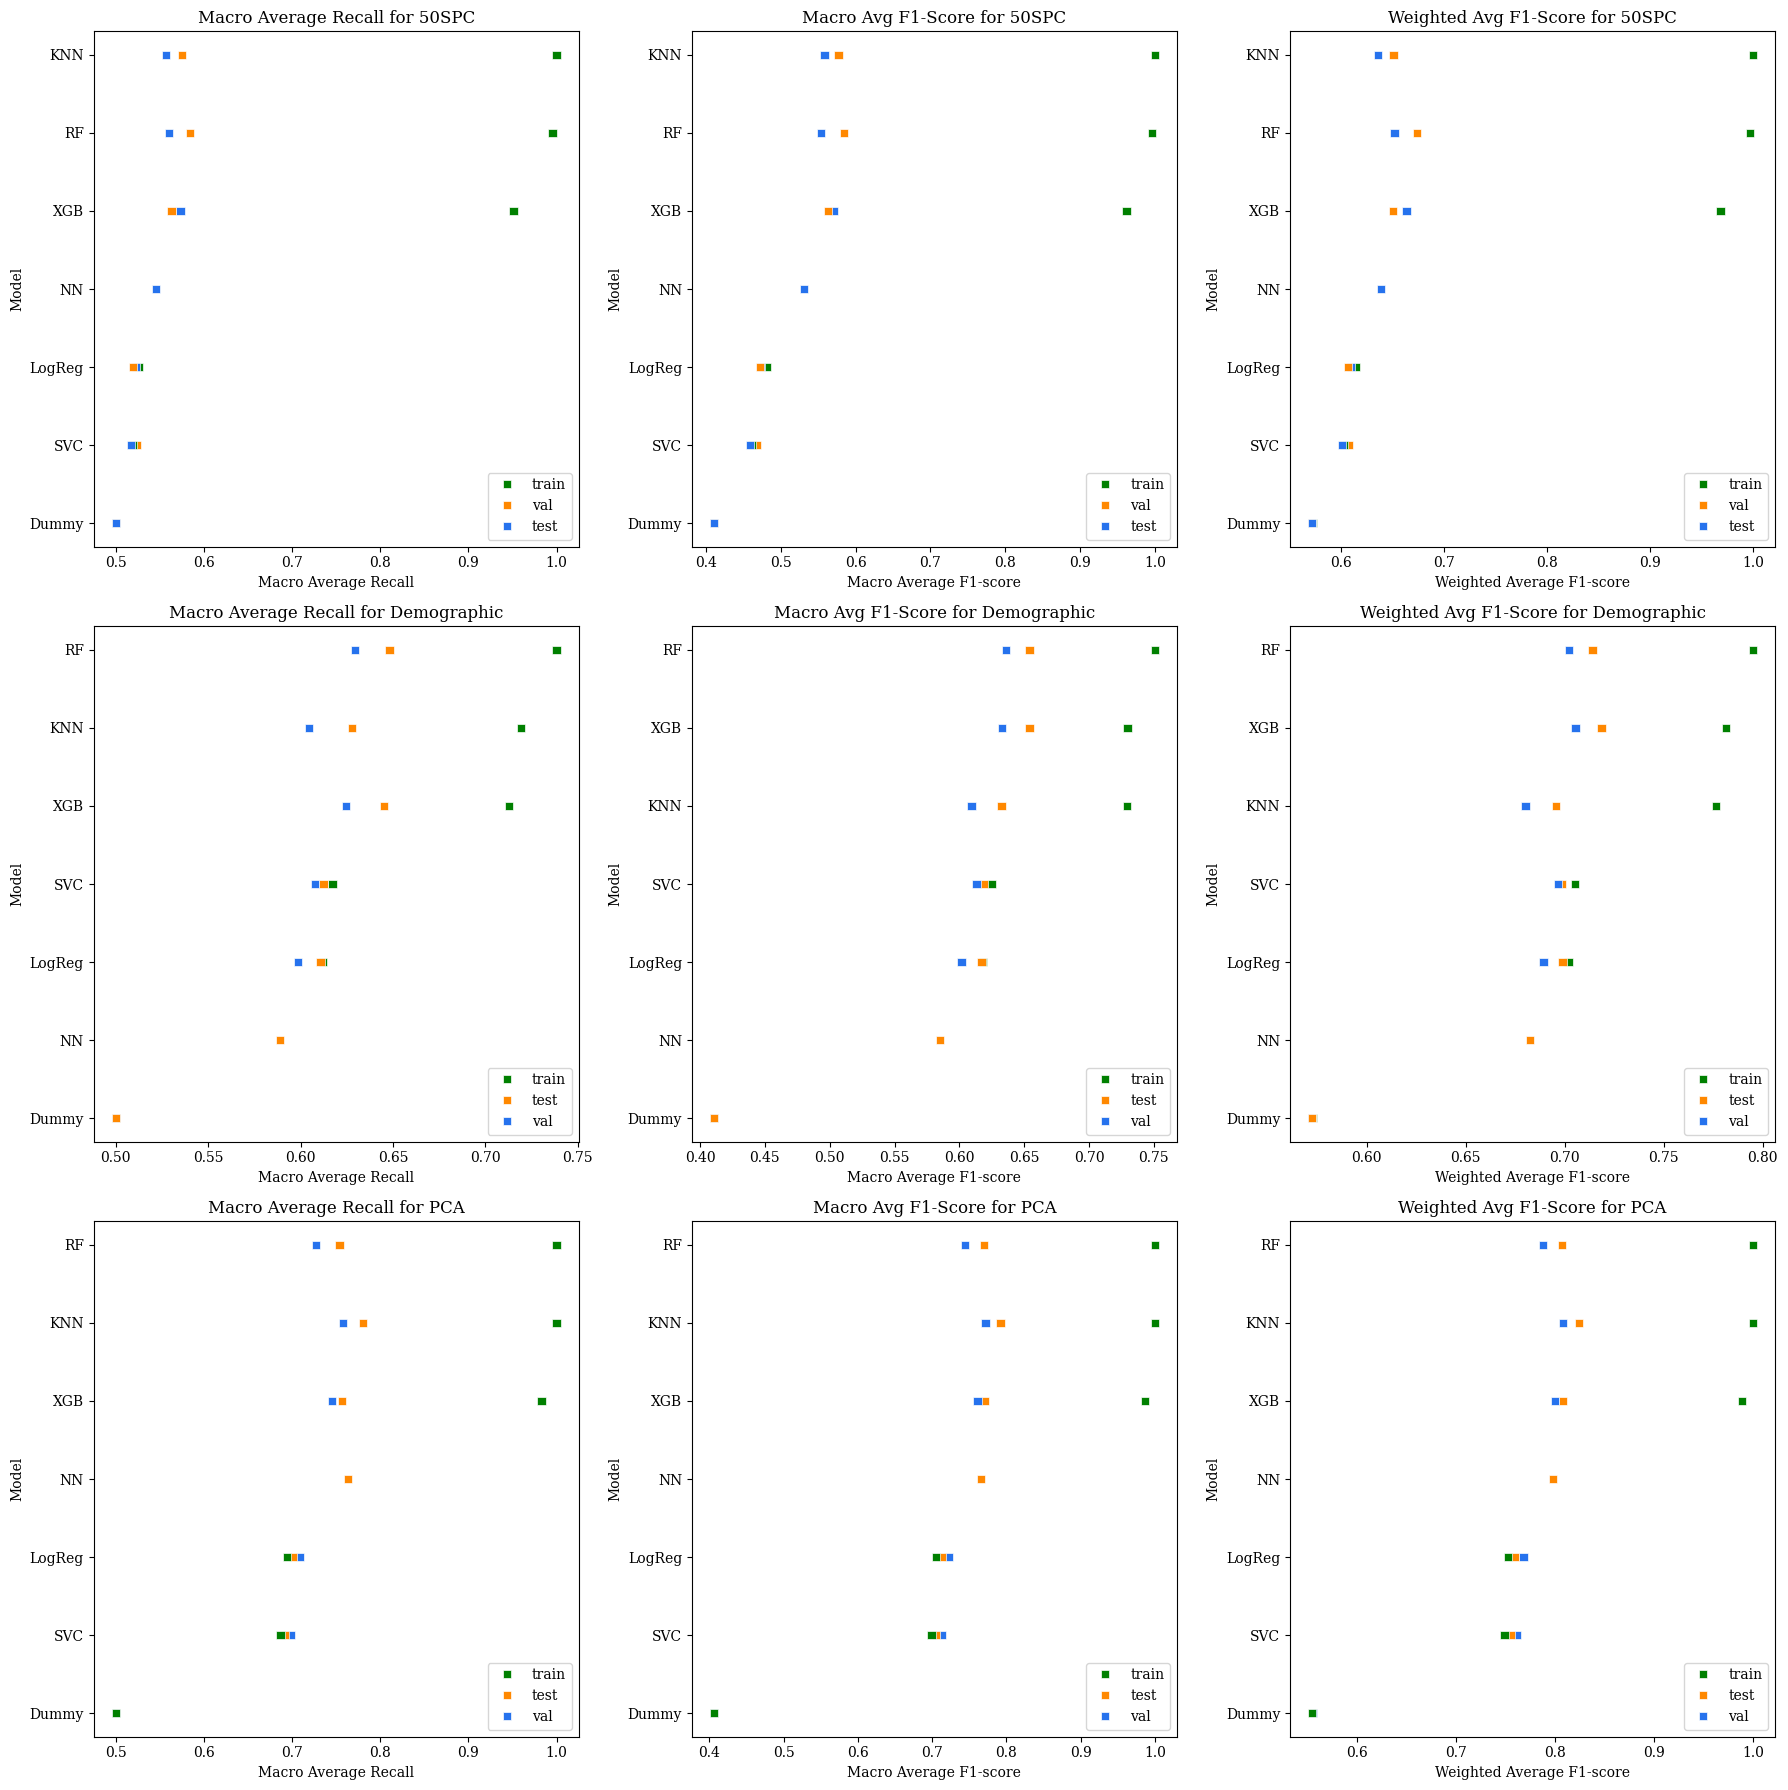

In [60]:
# make one 3x3 plot to save
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a larger figure to hold all subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  
axes = axes.flatten()

directory_idx = 0 

for directory in metrics_to_plot_df['Directory'].unique():
    if directory_idx >= 9:  # more than 9 directories, adjust the subplots accordingly
        break
    # Filter the DataFrame for the current directory
    subset_df = metrics_to_plot_df[metrics_to_plot_df['Directory'] == directory]
    
    # Sort the DataFrame by metrics for each plot
    sorted_df_mar = subset_df.sort_values(by='macro_avg_recall', ascending=False)
    sorted_df_maf1 = subset_df.sort_values(by='macro_avg_f1-score', ascending=False)
    sorted_df_waf1 = subset_df.sort_values(by='weighted_avg_f1-score', ascending=False)
    
    # Plot macro_avg_recall
    mar_plot = sns.scatterplot(ax=axes[3 * directory_idx + 0], data=sorted_df_mar, y='Model', x='macro_avg_recall', 
                    marker='s', hue='Split', palette=['green', '#ff8800', '#2672ed'])
    axes[3 * directory_idx + 0].set_title(f'Macro Average Recall for {directory}')
    axes[3 * directory_idx + 0].set_xlabel("Macro Average Recall")
    # Set legend position
    mar_plot.legend(loc='lower right')

    # Plot macro_avg_f1-score
    maf1_plot = sns.scatterplot(ax=axes[3 * directory_idx + 1], data=sorted_df_maf1, y='Model', x='macro_avg_f1-score', 
                    marker='s', hue='Split', palette=['green', '#ff8800', '#2672ed'])
    axes[3 * directory_idx + 1].set_title(f'Macro Avg F1-Score for {directory}')
    axes[3 * directory_idx + 1].set_xlabel("Macro Average F1-score")
    # Set legend position
    maf1_plot.legend(loc='lower right')

    # Plot weighted_avg_f1-score
    waf1_plot = sns.scatterplot(ax=axes[3 * directory_idx + 2], data=sorted_df_waf1, y='Model', x='weighted_avg_f1-score', 
                    marker='s', hue='Split', palette=['green', '#ff8800', '#2672ed'])
    axes[3 * directory_idx + 2].set_title(f'Weighted Avg F1-Score for {directory}')
    axes[3 * directory_idx + 2].set_xlabel("Weighted Average F1-score")
    # Set legend position
    waf1_plot.legend(loc='lower right')

    directory_idx += 1  # Increment directory index

# Adjust layout
plt.tight_layout()
# Save the entire figure
plt.savefig(figs_root / 'metrics_datasplits.png')
# Optionally show the plot
plt.show()



# Random Forest Confusion Matrix Plots (imb data only)

In [192]:
# set default font size
plt.rcParams.update({'font.size': 22})
# set default legend font size
plt.rcParams.update({'legend.fontsize': 22})

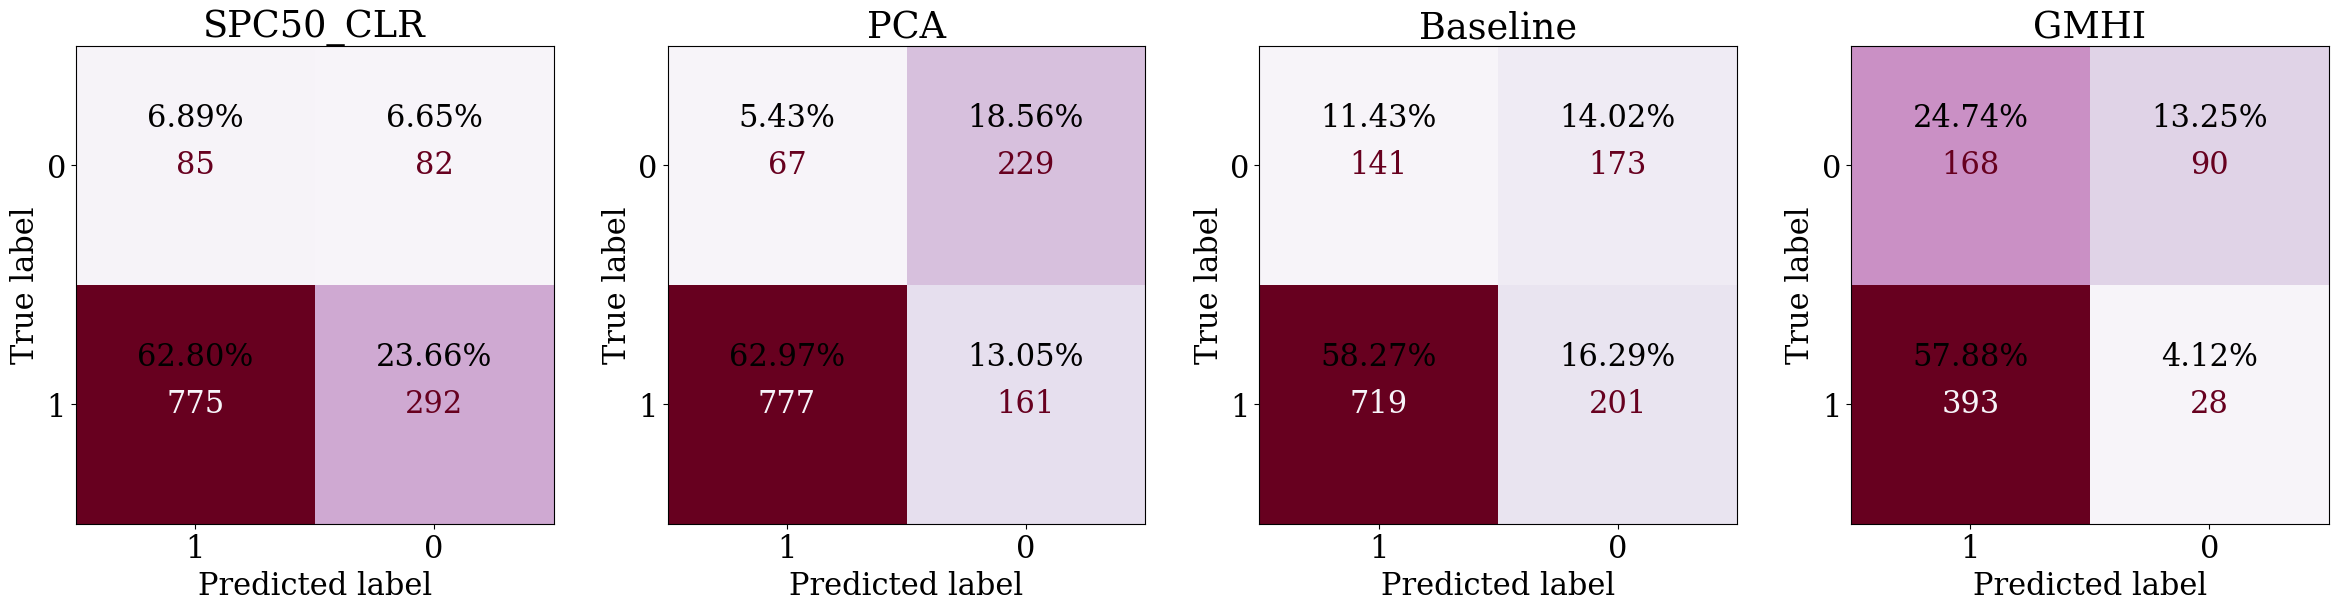

In [196]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

# Paths
root = Path.cwd().parents[1]
results_root = root / "results/model_reports/"
figs_root = root / "figs"
figs_root.mkdir(parents=True, exist_ok=True)  # creating the directory if it does not exist
RF_report = 'Random_Forest_Optimized_results.txt'
SPC50_CLR = '50SPC_CLR'
PCA = 'CLR_PCA_LowAbFilt'
Baseline = 'baseline'
GMHI_report_path = results_root / 'GMHI' / 'GMHI_results.txt'

def extract_confusion_matrix(data, dataset_name=''):
    # extract the test-part using regular expressions
    if dataset_name == 'GMHI':
        test_part = re.search(r"GHMI - test - Accuracy: [\s\S]*?weighted avg: \{'precision': [\d\.]+, 'recall': [\d\.]+, 'f1-score': [\d\.]+, 'support': [\d\.]+}", data)
    else:
        test_part = re.search(r"Random_Forest_Optimized - test - Accuracy: [\s\S]*?weighted avg: \{'precision': [\d\.]+, 'recall': [\d\.]+, 'f1-score': [\d\.]+, 'support': [\d\.]+}", data)
    
    if not test_part:
        raise ValueError("Test part not found in the data.")
    test_part = test_part.group()
    
    # extract the counts for each class
    support_0 = re.search(r"0: \{[\s\S]*?'support': ([\d\.]+)", test_part)
    support_1 = re.search(r"1: \{[\s\S]*?'support': ([\d\.]+)", test_part)
    
    if not support_0 or not support_1:
        raise ValueError("Support values not found in the test part.")
    
    support_0 = int(float(support_0.group(1)))
    support_1 = int(float(support_1.group(1)))
    
    # extract the recall values
    recall_0 = re.search(r"0: \{[\s\S]*?'recall': ([\d\.]+)", test_part)
    recall_1 = re.search(r"1: \{[\s\S]*?'recall': ([\d\.]+)", test_part)
    
    if not recall_0 or not recall_1:
        raise ValueError("Recall values not found in the test part.")
    
    recall_0 = float(recall_0.group(1))
    recall_1 = float(recall_1.group(1))
    
    # calculate the true positives and false negatives for each class
    tp_0 = int(recall_0 * support_0)
    fn_0 = support_0 - tp_0
    
    tp_1 = int(recall_1 * support_1)
    fn_1 = support_1 - tp_1
    
    # assumption: False positives for one class are false negatives for the other
    fp_0 = fn_1
    fp_1 = fn_0
    
    # construct the confusion matrix
    conf_matrix = np.array([[tp_0, fp_0],
                            [fp_1, tp_1]])
    return conf_matrix

def read_report(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    return data

def plot_confusion_matrix(cm, ax, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot(ax=ax, cmap='PuRd', colorbar=False) 
    ax.title.set_text(title)
    ax.invert_yaxis()  # Invert the y-axis
    ax.set_xticklabels([1, 0])  # Reverse the x-axis labels so the matrice is easier to read
    ax.set_yticklabels([1, 0])  # Reverse the y-axis labels so the matrice is easier to read
    # add percentages to compare the values in the matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = count / cm.sum() * 100
            ax.text(j, i + 0.2, f'{percentage:.2f}%', ha='center', va='center', color='black')

# read the Random Forest reports
reports = {
    'SPC50_CLR': read_report(results_root / SPC50_CLR / RF_report),
    'PCA': read_report(results_root / PCA / RF_report),
    'Baseline': read_report(results_root / Baseline / RF_report),
    'GMHI': read_report(GMHI_report_path)
}

# extract confusion matrices
conf_matrices = {}
for key, data in reports.items():
    try:
        dataset_name = 'GMHI' if key == 'GMHI' else 'Random_Forest_Optimized'
        conf_matrices[key] = extract_confusion_matrix(data, dataset_name=dataset_name)
    except ValueError as e:
        print(f"Error processing {key}: {e}")

# plot confusion matrices in a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for ax, (title, cm) in zip(axes, conf_matrices.items()):
    plot_confusion_matrix(cm, ax, title)

plt.tight_layout()

# save the figure
fig.savefig(figs_root / 'confusion_matrices.png', dpi=300)

plt.show()
